# Best Video Game Analysis

### 1. Introduction: In this project, we will be trying to determine which is the best video game ever. (Released on steam)

In this project, we aim to determine which is the best video game released on Steam. Since it would be impossible to analyze every game ever created, we will focus on Steam, one of the largest digital platforms for PC games. The dataset we are using contains games going back to 1997 and includes around 200,000 entries — a sufficiently large sample for meaningful analysis.

Our goal is to rank these games based on statistics, taking into account factors like playtime, reviews, achievements, and ownership.

### 2. Data preperation / Cleaning: 
While searching for a clean, up to date dataset I realized there are none, so I tried to create my own using the Steam API with a combination of the Steam SPY API. Unfortunately due to those API's having rate limits, a lot of uneeded (for us) data about trailers, DLC's and such, limitations and data hidden behind a paywall (for Steam SPY) I was unable to create my own dataset. I used the best one I could find which was a dataset from Kaggle, it faced the same issues as me so there is missing data for some games and features. But as Data Scientists we work with what we have.

As mentioned, the sources the dataset creator used, are the same ones I tried to use:
- Steam API has the official MetaData (release data, price, developers)
- Steam Spy has estimated/publically scraped data (owners, playtime, achivements)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, Video, display
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px

import src.utils as utils

In [4]:
# Setting the display.max_columns so I can see all columns in the DataFrame
pd.set_option('display.max_columns', None)
games = pd.read_csv("../data/games.csv")

# I added a header 'test' since the dataset was missing one, which caused issues when loading the data. The data for that header is 98% zeroes and since I got no idea what it is, I will
# remove it.
games.drop(columns=['test'], inplace=True)

# turn column names to snake case so it's easier to work with and I won't have to deal with spaces
games.columns = games.columns.str.lower().str.replace(' ', '_')

# The dataset has a lot of empty duplicates so I will get the valid one for each game
games = games.loc[
    games.groupby('name')['median_playtime_forever'].idxmax()
]

# Deserialize release_date into separate columns
games['release_date'] = pd.to_datetime(games['release_date'], errors='coerce')

games['release_year'] = games['release_date'].dt.year
games['release_month'] = games['release_date'].dt.month
games['release_day'] = games['release_date'].dt.day

# Handle missing values and convert to int (from float)
games['release_year'] = games['release_year'].fillna(2025).astype(int) 
games['release_month'] = games['release_month'].fillna(1).astype(int)
games['release_day'] = games['release_day'].fillna(1).astype(int)

# I will drop the user_score because most of the data has 0 due to unavailable statistics, not because the score is 0. This will introduce a huge bias later if kept in.
games.drop(columns=['release_date', 'user_score'], inplace=True)

# Now, I will convert the bool values into numerical ones for easier analysis
bool_columns = games.select_dtypes(include=['bool']).columns
games[bool_columns] = games[bool_columns].astype(int)

# I will create columns for number of entries where we have an array of categories (ex: tags, genres, etc.)
games['num_supported_languages'] = games.supported_languages.fillna('').str.split(',').apply(utils.get_string_array_length)
games['num_supported_audio_languages'] = games.full_audio_languages.fillna('').str.split(',').apply(utils.get_string_array_length)
games['num_tags'] = games.tags.fillna('').str.split(',').apply(utils.get_string_array_length)
games['num_genres'] = games.genres.fillna('').str.split(',').apply(utils.get_string_array_length)
games['num_categories'] = games.categories.fillna('').str.split(',').apply(utils.get_string_array_length)
games.head(5)

games = games.rename(columns={'peak_ccu': 'peak_concurrent_users'})

# I will also normalize the estimated_owners column so we can actually use the data. Will use the formula x_standard = (x - mean) / std
games['owners_count'] = games.estimated_owners.apply(utils.range_to_average)

# Save cleaned dataset
games.to_csv('../data/games_cleaned.csv', index=False)

### 3. Data Visualization

Let's visualize what we have so far.

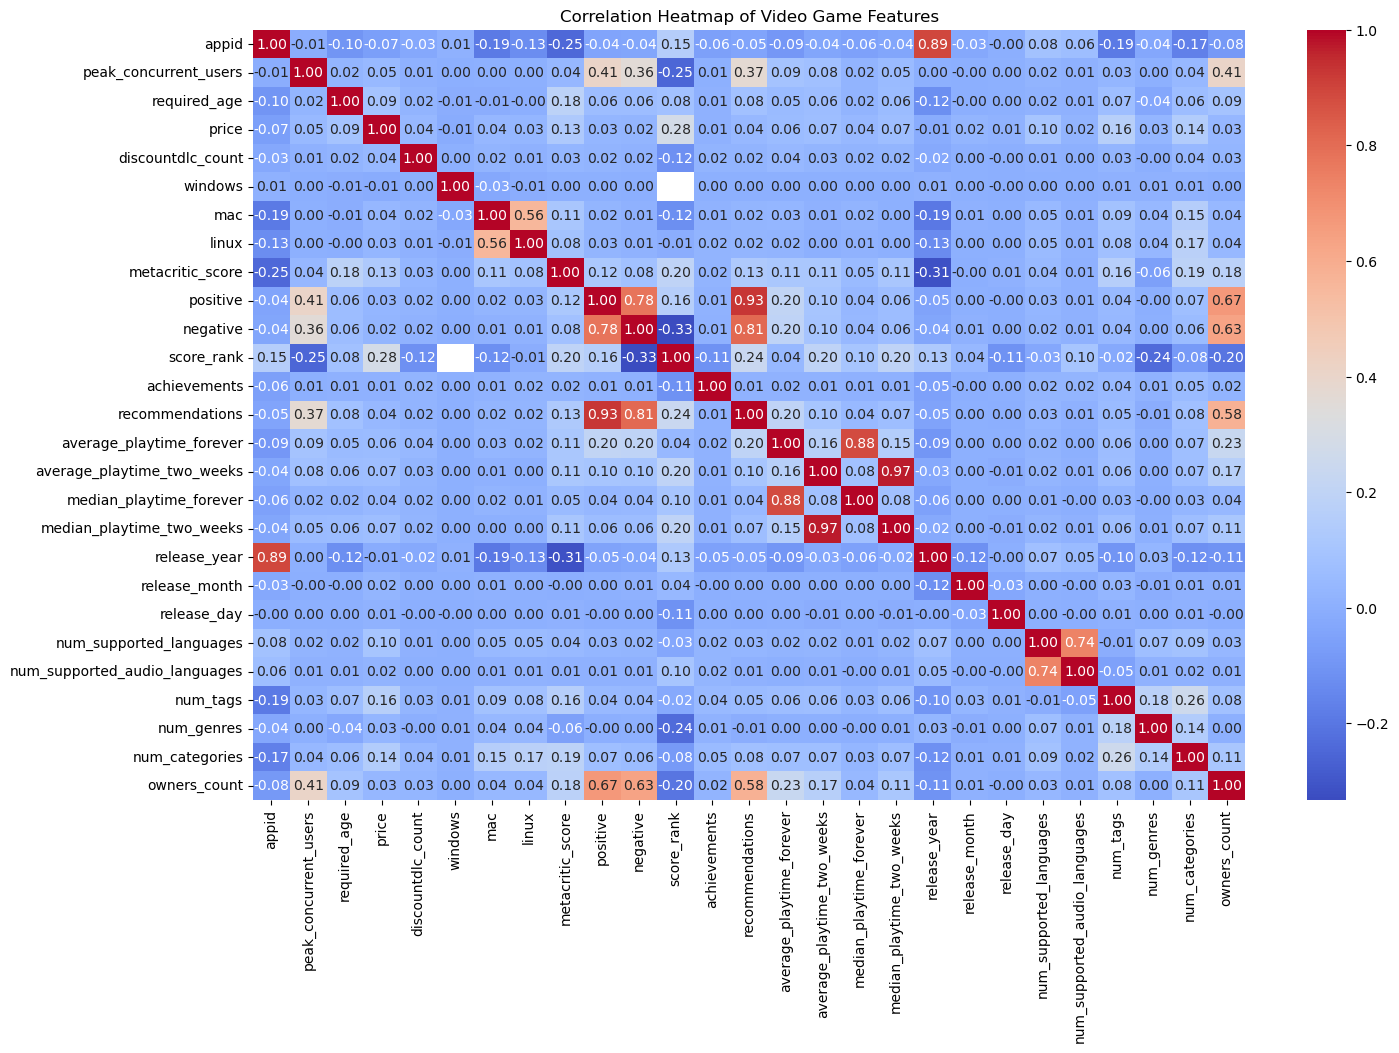

In [5]:
# Now let's display a correlation matrix for visualization.
plt.figure(figsize=(16, 10))
sns.heatmap(games.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Video Game Features')
plt.show()

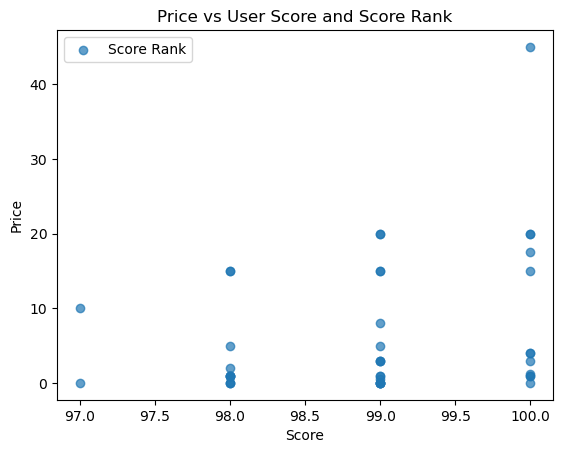

In [6]:
# The price has a positive correlation to the score_rank, as we can see, the more expensive the game, the higher the score.
# Meaning the best games are usually the most expensive ones. (let's keep that in mind)
plt.scatter(games['score_rank'], games['price'], label='Score Rank', alpha=0.7)

plt.xlabel('Score')
plt.ylabel('Price')
plt.title('Price vs User Score and Score Rank')
plt.legend()
plt.show()

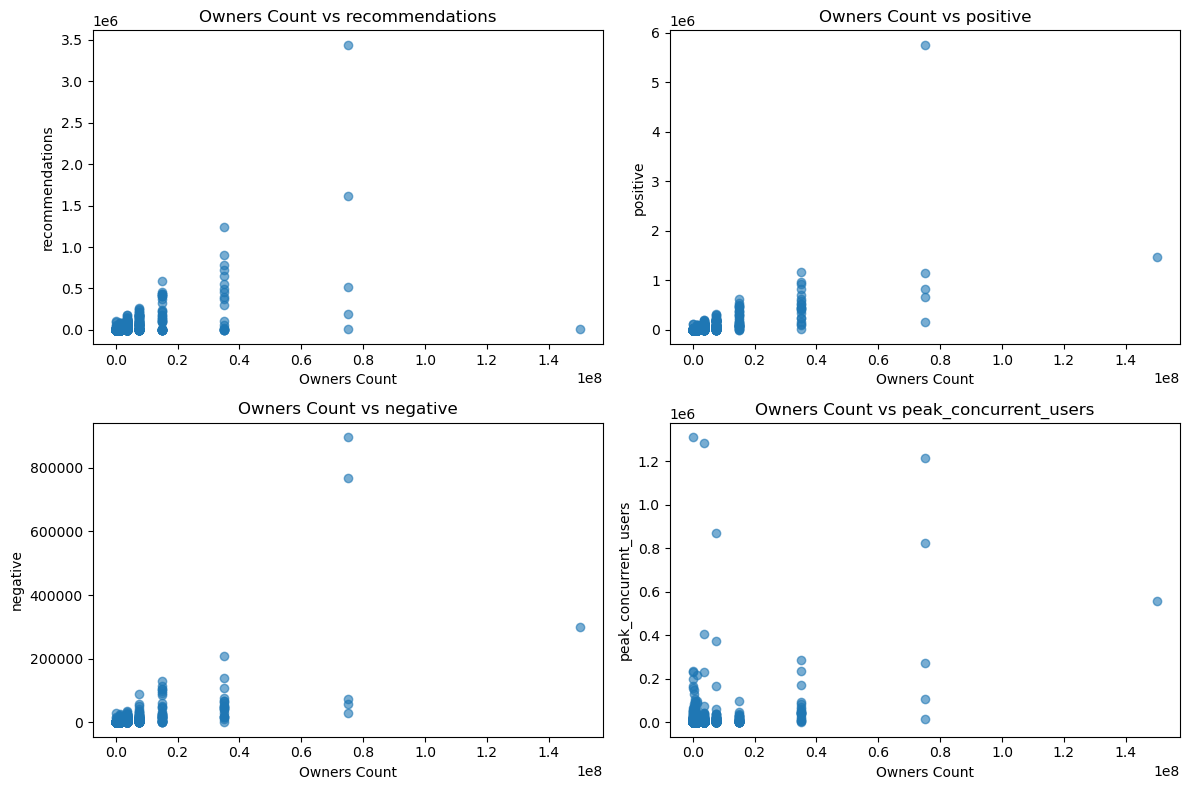

In [7]:
cols = ['recommendations', 'positive', 'negative', 'peak_concurrent_users']

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(2, 2, i)
    plt.scatter(games['owners_count'], games[col], alpha=0.6)
    plt.xlabel('Owners Count')
    plt.ylabel(col)
    plt.title(f'Owners Count vs {col}')

plt.tight_layout()
plt.show()

# With this plot we can confirm that the more players we have, the more recommendations, positive reviews, negative reviews, and peak concurrent users increase.
# Which is obvious most of the time, but we still need to validate our assumptions with data.

### 4. Feature Engineering

#### I will need a formula to calculate retention score for the games. This will help me formulate the final formula which I will use to determine the best game based on the data from this dataset.

The problem is, the best game is subjective for everyone, some people prefer older games, some newer, some prefer fps, some moba. In order for there to be no bias, I will create a formula, which combines the most important features (high correlation) and calculates a score for each game. But first, I want a retention score feature, which tells us how much of the playerbase stuck around after the initial launch.

Something like $$retention\_score = (avg\_playtime\_2w / avg\_playtime\_forever + 1) * \log(1 + game\_age)$$

Where we use **log scaling** due to outliers.

Where:
- Close to 1 → people are still playing as much now as ever.
- Close to 0 → game is basically dead.
- We apply an age based weight - $retention\_score * \log(1 + game\_age)$ and use logarithm to normalize the result (boost retention for old games, close to no boost)

In [8]:
# Game age in years (adjust for your dataset year)
games['game_age'] = 2025 - games['release_year']

# Basic retention ratio, adjust by age (log scaling so it doesn’t explode for very old games)
# average_playtime_forever + 1 is to avoid division by zero error
# log1p (1 + log) avoids log(0) issues
games['retention_score'] = (games['average_playtime_two_weeks'] / (games['average_playtime_forever'] + 1) * np.log1p(games['game_age']))

games[games.name.str.contains('Tom Clancy')]

,appid,name,estimated_owners,peak_concurrent_users,required_age,price,discountdlc_count,about_the_game,supported_languages,full_audio_languages,reviews,header_image,website,support_url,support_email,windows,mac,linux,metacritic_score,metacritic_url,positive,negative,score_rank,achievements,recommendations,notes,average_playtime_forever,average_playtime_two_weeks,median_playtime_forever,median_playtime_two_weeks,developers,publishers,categories,genres,tags,screenshots,movies,release_year,release_month,release_day,num_supported_languages,num_supported_audio_languages,num_tags,num_genres,num_categories,owners_count,game_age,retention_score
25075,21800,Tom Clancy's EndWar™,100000 - 200000,19,0,9.99,0,Live the thrilling career of an army commander...,"['English', 'French', 'German', 'Italian', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://endwargame.us.ubi.com/,NaN,NaN,1,0,0,68,https://www.metacritic.com/game/pc/tom-clancys...,539,143,NaN,0,643,NaN,262,0,467,0,Ubisoft Shanghaï,Ubisoft,"Single-player,Multi-player",Strategy,"Strategy,RTS,Tactical,Voice Control,War,Single...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,2009,2,25,5,1,8,1,2,150000,16,0.000000
49691,212630,Tom Clancy's Ghost Recon: Future Soldier™,200000 - 500000,16,17,19.99,4,"There is nothing fair, honorable, or just abou...","['English', 'Danish', 'Dutch', 'French', 'Germ...","['English', 'French', 'German', 'Italian', 'Sp...",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.ghostrecon.com/,https://support.ubi.com/,NaN,1,0,0,71,https://www.metacritic.com/game/pc/tom-clancys...,3045,1478,NaN,0,3885,NaN,329,0,206,0,"Ubisoft Paris,Red Storm Entertainment",Ubisoft,"Single-player,Multi-player,Co-op",Action,"Action,Stealth,Third-Person Shooter,Co-op,Tact...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,2012,6,26,11,6,20,1,3,350000,13,0.000000
40814,15300,Tom Clancy's Ghost Recon®,200000 - 500000,16,17,9.99,0,"Eastern Europe, 2008. War has broken out on th...",['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://ghostrecon.us.ubi.com/,NaN,NaN,1,0,0,80,https://www.metacritic.com/game/pc/tom-clancys...,992,76,NaN,0,999,NaN,27,0,30,0,Red Storm Entertainment,Ubisoft,"Single-player,Co-op",Action,"Tactical,FPS,Action,Simulation,Shooter,Classic...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,2008,7,15,1,1,17,1,2,350000,17,0.000000
69053,2231380,Tom Clancy's Ghost Recon® Breakpoint,50000 - 100000,9048,17,12.00,1,Explore a treacherous archipelago Explore Auro...,"['English', 'French', 'Italian', 'German', 'Sp...","['English', 'French', 'Italian', 'German', 'Sp...",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://ghost-recon.ubisoft.com/,https://support.ubi.com/,NaN,1,0,0,0,NaN,864,824,NaN,0,1932,NaN,281,281,338,338,Ubisoft Paris,Ubisoft,"Single-player,Multi-player,Co-op,Online Co-op,...","Action,Adventure","Action,Adventure,Shooter,Third-Person Shooter,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,2023,1,23,16,10,17,2,5,75000,2,1.094717
16755,13620,Tom Clancy's Ghost Recon® Desert Siege™,200000 - 500000,3,17,4.99,0,"East Africa, 2009. A 60-year conflict boils ov...",['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.ghostrecon.com/us/product_grds.php,NaN,NaN,1,0,0,82,https://www.metacritic.com/game/pc/tom-clancys...,82,5,NaN,0,0,NaN,1,0,1,0,Red Storm Entertainment,Ubisoft,"Single-player,Multi-player",Action,"Action,Shooter,FPS,First-Person,Tactical,Strategy",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,2008,7,15,1,1,6,1,2,350000,17,0.000000
38378,13630,Tom Clancy's Ghost Recon® Island Thunder™,20000 - 50000,2,0,4.99,0,Ghost Recon takes the next step in battlefield...,['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.ghostrecon.com/us/product_grit.php,NaN,NaN,1,0,0,82,https://www.metacritic.com/game/pc/tom-clancys...,81,12,NaN,0,0,NaN,2,0,2,0,Red Storm En

### 5. Hypothesis testing

Now I will use some correlation and hypothesis testing in order to find which features are best to use for the final equation.

First I will check the linear relationships with Pearson's correlation coefficient.

In [9]:
# Correlation between retention_score and average_playtime_two_weeks
corr, pval = pearsonr(games.retention_score, games.average_playtime_two_weeks)
print(f"Pearson correlation: {corr:.3f}, p-value: {pval:.3f}")

# Obviously very good as we used average_playtime_two_weeks to construct the equastion.

Pearson correlation: 0.578, p-value: 0.000


In [10]:
# Correlation between retention_score and median_playtime_forever
corr, pval = pearsonr(games.retention_score, games.median_playtime_forever)
print(f"Pearson correlation: {corr:.3f}, p-value: {pval:.3f}")

# Strange, almost no correlation, you would think most features contribute to retention.

Pearson correlation: 0.018, p-value: 0.000


In [11]:
# Correlation between retention_score and positive
corr, pval = pearsonr(games.retention_score, games.positive)
print(f"Pearson correlation: {corr:.3f}, p-value: {pval:.3f}")

# Hmm, seems like there is almost no correlation between our new feature and the fields outside the equation.

Pearson correlation: 0.035, p-value: 0.000


Maybe the replationship with the features and our generated retention_score is simply not linear, lets try to use Spearman's correlation coefficient to see if the relationship is curved.

In [12]:
corr, p_value = spearmanr(games.retention_score, games.median_playtime_forever)
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3e}")

# Alright, we can see that there is indeed a positive correlation between retention_score and owners_count.
# The p-value is very low, meaning it's not random.

Spearman correlation: 0.377, p-value: 0.000e+00


In [13]:
corr, p_value = spearmanr(games.retention_score, games.average_playtime_forever)
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3e}")

# average playtime forever has a positive correlation, we can use it too.

Spearman correlation: 0.384, p-value: 0.000e+00


In [14]:
corr, p_value = spearmanr(games.retention_score, games.peak_concurrent_users)
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3e}")

# Positive correlation and almost zero p-value indicate a strong relationship.

Spearman correlation: 0.297, p-value: 0.000e+00


In [15]:
# Let's test the positive too
corr, pval = pearsonr(games.retention_score, games.positive)
print(f"Pearson correlation: {corr:.3f}, p-value: {pval:.3f}")

# Okay, positive reviews still have no correlation, good to know.

Pearson correlation: 0.035, p-value: 0.000


In [16]:
corr, p_value = spearmanr(games.retention_score, games.price)
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3e}")

# Price has a slight correlation too, not enough to be used tho.
# I was hoping we can use this in feature engineering but it seems the correlation is not strong enough.

Spearman correlation: 0.142, p-value: 0.000e+00


In [17]:
corr, p_value = spearmanr(games.retention_score, games.median_playtime_forever)
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3e}")

# Interesting, the release_year has a negative correlation on the median playtime forever, meaning older games tend to have lower playtime, even they have been out for longer.

Spearman correlation: 0.377, p-value: 0.000e+00


In [18]:
corr, p_value = spearmanr(games.retention_score, games.recommendations)
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3e}")

# Recommendations has a negative correlation, meaning older games tend to receive fewer recommendations.

Spearman correlation: 0.359, p-value: 0.000e+00


In [19]:
corr, p_value = spearmanr(games.retention_score, games.game_age)
print(f"Spearman correlation: {corr:.3f}, p-value: {p_value:.3e}")

# Game age has almost no correlation and a high p-value, indicating it's not a significant factor.

Spearman correlation: 0.068, p-value: 2.225e-114


### Now... after looking at the retention_score i quickly realize how bad this dataset it, Rainbow 6 Siege has a score of 0.1, while Ghost Recon has 1.1 lol. This is maddness.
Unfortunately, as data scientists we work with what we have, maybe if Steam API didnt have so much restrictions and I could create my own dataset it would be better.

Anyways, now that we have a very good feature, we might be able to create a **BGI (Best Game Index)** as a weighted combination between some fields.

The fields I will use are: *owners_count, retention_score, retention_score, peak_concurrent_users, recommendations, positive, negative, average_playtime_forever, median_playtime_forever*.
Some of them will be used seperately to create one normalized field.
I will normalize them, then add a weight for each one and calculate the score.

<div style="height: 1.5rem;"></div>

$$
\text{ReviewScore} = \frac{(P \cdot N - \alpha)}{P + N + 1}
$$  
Where:  
- $P$ = number of positive reviews  
- $N$ = number of negative reviews  
- $\alpha = 1.5$ (bias factor to account for review imbalance)

<div style="height: 2.5rem;"></div>

$$
\text{PlaytimeScore} = \frac{\text{AvgPlaytime}_{\infty} + \text{MedianPlaytime}_{\infty}}{2}
$$  
Where:  
- $\text{AvgPlaytime}_{\infty}$ = average playtime (forever)  
- $\text{MedianPlaytime}_{\infty}$ = median playtime (forever)  

<div style="height: 2.5rem;"></div>

$$
\text{GameScore} =
w_1 \cdot O +
w_2 \cdot R +
w_3 \cdot C +
w_4 \cdot Rec +
w_5 \cdot \text{ReviewScore} +
w_6 \cdot \text{PlaytimeScore}
$$  
Where:  
- $O$ = owners count  
- $R$ = retention score  
- $C$ = peak concurrent users  
- $Rec$ = recommendations  
- $w_i$ = feature weights (sum to 1)  


In [ ]:
scaler = MinMaxScaler()
cols = [
    'owners_count',
    'retention_score',
    'peak_concurrent_users',
    'recommendations'
]

games_norm = games.copy()

# Calculate the review score, favoring the positive reviews
alpha = 1.5
games_norm['review_score'] = (
    (games['positive'] * games['negative'] - alpha) / # positive reviews count 50% more as most people leave a review only if it's negative
    (games['positive'] + games['negative'] + 1)
)

games_norm['playtime_score'] = (games_norm['average_playtime_forever'] + games_norm['median_playtime_forever']) / 2

cols = cols + ['review_score', 'playtime_score']
# Normalize all columns for consistency
games_norm[cols] = scaler.fit_transform(games_norm[cols])

weights = {
    'owners_count': 0.15,
    'retention_score': 0.30,
    'peak_concurrent_users': 0.20,
    'recommendations': 0.15,
    'review_score': 0.10,
    'playtime_score': 0.15
}

games_norm['GameScore'] = (
    weights['owners_count'] * games_norm['owners_count'] +
    weights['retention_score'] * games_norm['retention_score'] +
    weights['peak_concurrent_users'] * games_norm['peak_concurrent_users'] +
    weights['recommendations'] * games_norm['recommendations'] +
    weights['review_score'] * games_norm['review_score'] +
    weights['playtime_score'] * games_norm['playtime_score']
)

# Simply add the GameScore to the real dataset and save it for future use.
games['GameScore'] = games_norm['GameScore']
games.to_csv('../data/best_video_games.csv', index=False)

                            name  GameScore
Counter-Strike: Global Offensive   0.468913
                      Just Cause   0.301908
              Black Myth: Wukong   0.292539
                          Dota 2   0.291635
             PUBG: BATTLEGROUNDS   0.276415
                        Palworld   0.205505
            Monster Hunter Wilds   0.204795
                            GRID   0.154081
              Grand Theft Auto V   0.151909
 Energy Engine PC Live Wallpaper   0.150263
                 Hogwarts Legacy   0.150061
                       Crysis® 3   0.147564
              Narcissu 1st & 2nd   0.142185
  Alan Wake's American Nightmare   0.142078
                         Boom 3D   0.139896
           STAR WARS™: Squadrons   0.130547
                 NEKOPARA Vol. 0   0.128043
  Command & Conquer: Red Alert 3   0.112943
                 Team Fortress 2   0.108737
                  NEKOPARA Extra   0.108461


In [31]:
# Now let's visualize it with plotly
top_games = games.sort_values('GameScore', ascending=False)[["name", "GameScore"]].head(20)

# get top 20 games
top = top_games.nlargest(20, "GameScore").copy()

fig = px.bar(
    top,
    x="GameScore", 
    y="name",
    orientation="h",
    hover_data={
        "GameScore": ":.3f"
    },
    title="Top 20 Games by GameScore"
)

fig.update_layout(
    yaxis=dict(
        categoryorder="total ascending",   # rank nicely
        automargin=True                    # let Plotly add space for labels
    ),
    margin=dict(l=200, r=40, t=80, b=40),  # widen left margin for long names
    height=600                             # increase figure height
)
fig.show()

Let's check if tweaking the weights changes the results. It should give different values but keep the overall arrangement.

In [ ]:
# Sensitivity check: random weight noise
def sample_weights(base, noise=0.1):
    arr = np.array(list(base.values()))
    arr = arr * (1 + np.random.uniform(-noise, noise, size=arr.shape))
    arr = np.clip(arr, 0, None)
    arr /= arr.sum()
    return dict(zip(base.keys(), arr))

# Compute overlap for top-10
base_top10 = best_games['name'].head(10).tolist()
overlaps = []
for i in range(100):
    w = sample_weights(weights, noise=0.1)
    games_norm['GameScore_temp'] = sum(w[k] * games_norm[k] for k in w)
    temp_top10 = games_norm.nlargest(10, 'GameScore_temp')['name'].tolist()
    overlaps.append(len(set(base_top10) & set(temp_top10)))

print("Average overlap with noise:", np.mean(overlaps))

# As we can see, we have a score of 8.95, meaning 9/10 times, when changind weights the arrangement of the result is the same, meaning the BGI is not heavily biased by those weights.
# Also meaning the score is reliable.

Average overlap with perturbation: 8.95


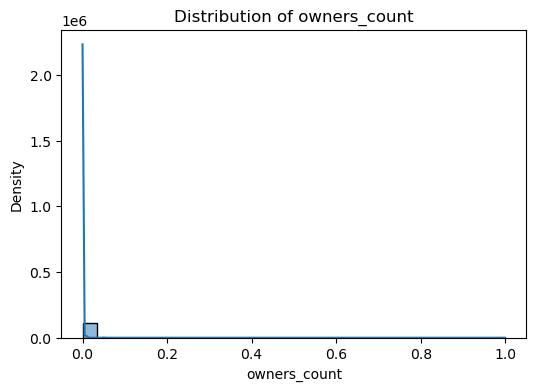

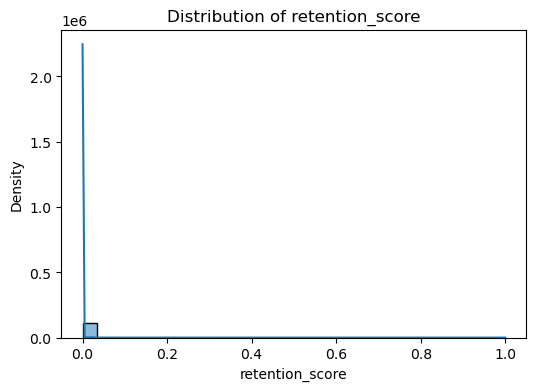

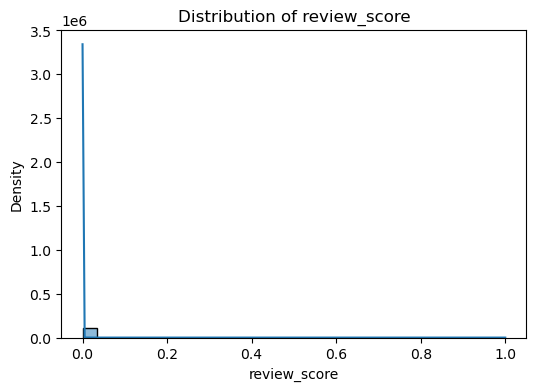

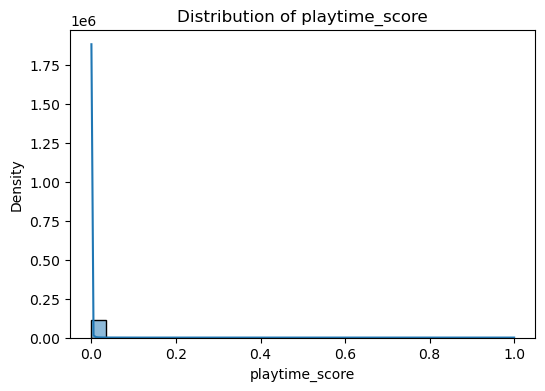

In [ ]:
features = ['owners_count', 'retention_score', 'review_score', 'playtime_score']

#  Sanity check: feature distributions
for f in features:
    plt.figure(figsize=(6,4))
    sns.histplot(games_norm[f], bins=30, kde=True)
    plt.title(f"Distribution of {f}")
    plt.xlabel(f)
    plt.ylabel('Density')
    plt.show()

# We see that the dataset is heavily skewed for failure.
# In our case we are trying to find the outliers, the winners.

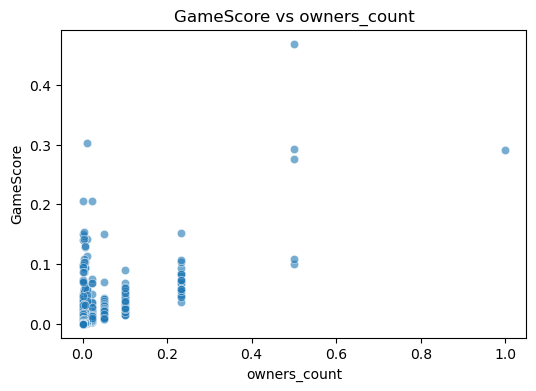

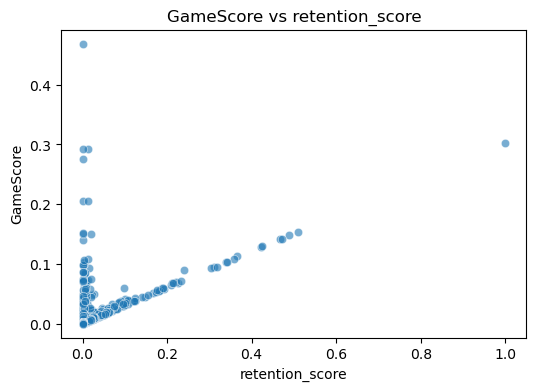

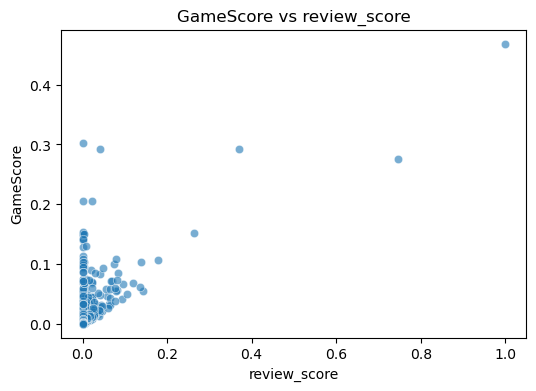

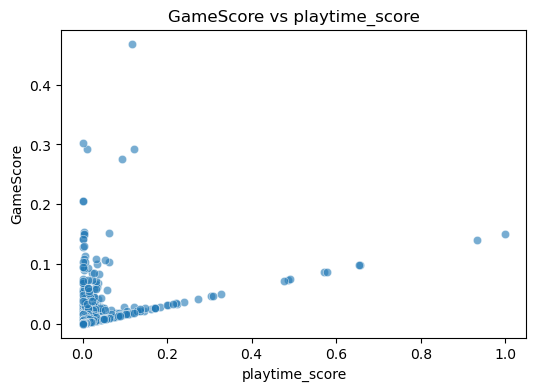

In [ ]:
# Sanity check: feature correlations
for f in features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=games_norm[f], y=games_norm['GameScore'], alpha=0.6)
    plt.title(f"GameScore vs {f}")
    plt.xlabel(f)
    plt.ylabel('GameScore')
    plt.show()

# We see that the feature correlations have a linear relationships, with owners_count being sparse/discontinuous